# CellDART Example Code: mouse brain 
## (10x Visium of anterior mouse brain + scRNA-seq data of mouse brain)

In [1]:
import glob
import os
from math import ceil

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error

from CellDART import da_cellfraction
from CellDART.utils import random_mix


In [2]:
NUM_MARKERS = 20
N_MIX = 8
N_SPOTS = 20000
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

SPATIALLIBD_DIR = "../AGrEDA/data/spatialLIBD"
SC_DLPFC_PATH = "../AGrEDA/data/sc_dlpfc/adata_sc_dlpfc.h5ad"


## 1. Data load
### load scanpy data - 10x datasets

In [3]:
SPATIALLIBD_DIR = "../AGrEDA/data/spatialLIBD"
SC_DLPFC_PATH = "../AGrEDA/data/sc_dlpfc/adata_sc_dlpfc.h5ad"

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(SPATIALLIBD_DIR, "adata")

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, "adata_spatialLIBD-*.h5ad")):
    sample_id = name.partition("-")[2].rpartition(".")[0]
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)


-----
anndata     0.8.0
scanpy      1.9.1
-----
CellDART                                    NA
PIL                                         9.2.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
asttokens                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
certifi                                     2022.06.15
cffi                                        1.15.1
charset_normalizer                          2.1.0
cycler                                      0.10.0
cython_runtime                              NA
dateutil                                    2.8.2
debugpy                                     1.6.2
decorator                                   5.1.1
defusedxml                                  0.7.1
entrypoints                                 0.4
executing         

In [4]:
adata_sc_dlpfc = sc.read_h5ad(SC_DLPFC_PATH)
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e4)
adata_sc_dlpfc.var_names_make_unique()


normalizing counts per cell
    finished (0:00:00)


In [5]:
# #Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])


In [6]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')


In [7]:
df_genelists = pd.read_pickle("../AGrEDA/data/sc_dlpfc/df_genelists.pkl")
res_genes = []
for column in df_genelists.head(NUM_MARKERS):
    res_genes.extend(df_genelists.head(NUM_MARKERS)[column].tolist())
res_genes_ = list(set(res_genes))


### Select same gene features 

In [8]:
adata_spatialLIBD = ad.concat(
    adata_spatialLIBD_d.values(), label="sample_id", keys=adata_spatialLIBD_d.keys()
)
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e4)
st_sample_id_l = adata_spatialLIBD.obs["sample_id"].unique()


normalizing counts per cell


/home/wma/miniconda3/envs/CellDART/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [9]:
adata_spatialLIBD.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print("Selected Feature Gene number", len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


Selected Feature Gene number 362


## Format Data

### Array of single cell & spatial data
- Single cell data with labels
- Spatial data without labels


### Generate Pseudospots

In [10]:
def log_minmaxscale(arr):
    """returns log1pc and min/max normalized arr"""
    arrd = len(arr)
    arr = np.log1p(arr)

    arr_minus_min = arr - np.reshape(np.min(arr, axis=1), (arrd, 1))
    min2max = np.reshape((np.max(arr, axis=1) - np.min(arr, axis=1)), (arrd, 1))
    return arr_minus_min / min2max


In [11]:
df_sc = adata_sc_dlpfc.to_df()
df_sc.index = pd.MultiIndex.from_frame(adata_sc_dlpfc.obs.reset_index())

sc_sub_dict = dict(zip(range(df_genelists.shape[1]), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())


In [12]:
lab_sc_sub = df_sc.index.get_level_values("cell_subclass")
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype="int")

mat_sc_train, mat_sc_eval, lab_sc_num_train, lab_sc_num_eval = train_test_split(
    df_sc.to_numpy(),
    lab_sc_num,
    test_size=0.2,
    random_state=225,
    stratify=lab_sc_num,
)
mat_sc_val, mat_sc_test, lab_sc_num_val, lab_sc_num_test = train_test_split(
    mat_sc_eval,
    lab_sc_num_eval,
    test_size=0.5,
    random_state=263,
    stratify=lab_sc_num_eval,
)

sc_mix_train, lab_mix_train = random_mix(
    mat_sc_train, lab_sc_num_train, nmix=N_MIX, n_samples=N_SPOTS
)
sc_mix_val, lab_mix_val = random_mix(
    mat_sc_val, lab_sc_num_val, nmix=N_MIX, n_samples=N_SPOTS // 8
)
sc_mix_test, lab_mix_test = random_mix(
    mat_sc_test, lab_sc_num_test, nmix=N_MIX, n_samples=N_SPOTS // 8
)


sc_mix_train_s = log_minmaxscale(sc_mix_train)
sc_mix_val_s = log_minmaxscale(sc_mix_val)
sc_mix_test_s = log_minmaxscale(sc_mix_test)


### Format Spatial Data

In [13]:
mat_sp_test_d = {}
mat_sp_test_s_d = {}
for sample_id in st_sample_id_l:
    mat_sp_test_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ].X.todense()

    mat_sp_test_s_d[sample_id] = log_minmaxscale(mat_sp_test_d[sample_id])

if TRAIN_USING_ALL_ST_SAMPLES:
    mat_sp_train = adata_spatialLIBD.X.todense()
    mat_sp_train_s = log_minmaxscale(mat_sp_train)
else:
    mat_sp_train_d = mat_sp_test_d
    mat_sp_train_s_d = mat_sp_test_s_d


## 3. Training: Adversarial domain adaptation for cell fraction estimation
### Parameters
- alpha: loss weights for adversarial learning for pooling domain classifier
- alpha_lr: learning rate for training domain classifier  (alpha_lr *0.001)
- emb_dim: embedding dimension (feature dimension)
- batch_size : batch size for the training
- n_iterations: iteration number of adversarial training
- initial_train: if true, classifier model is trained firstly before adversarial domain adaptation
- initial_train_epochs: number of epochs for inital training



In [14]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    embs, clssmodel, clssmodel_noda = da_cellfraction.train(
        sc_mix_train_s,
        lab_mix_train,
        mat_sp_train_s,
        alpha=0.6,
        alpha_lr=5,
        emb_dim=64,
        batch_size=512,
        n_iterations=3000,
        initial_train=True,
        initial_train_epochs=100,
    )
else:
    embs_d, clssmodel_d, clssmodel_noda_d = {}, {}, {}
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")
        embs, clssmodel, clssmodel_noda = da_cellfraction.train(
            sc_mix_train_s,
            lab_mix_train,
            mat_sp_train_s_d[sample_id],
            alpha=0.6,
            alpha_lr=5,
            emb_dim=64,
            batch_size=512,
            n_iterations=3000,
            initial_train=True,
            initial_train_epochs=100,
        )
        embs_d[sample_id] = embs
        clssmodel_d[sample_id] = clssmodel
        clssmodel_noda_d[sample_id] = clssmodel_noda


Train on 20000 samples
Epoch 1/100
20000/20000 [==============================] - 0s 24us/sample - loss: 1.1962 - mae: 0.0344
Epoch 2/100
20000/20000 [==============================] - 0s 17us/sample - loss: 0.8357 - mae: 0.0283
Epoch 3/100
20000/20000 [==============================] - 0s 17us/sample - loss: 0.6800 - mae: 0.0250
Epoch 4/100
20000/20000 [==============================] - 0s 17us/sample - loss: 0.6055 - mae: 0.0229
Epoch 5/100
20000/20000 [==============================] - 0s 17us/sample - loss: 0.5725 - mae: 0.0220
Epoch 6/100
20000/20000 [==============================] - 0s 18us/sample - loss: 0.5505 - mae: 0.0214
Epoch 7/100
20000/20000 [==============================] - 0s 18us/sample - loss: 0.5333 - mae: 0.0209
Epoch 8/100
20000/20000 [==============================] - 0s 18us/sample - loss: 0.5198 - mae: 0.0205
Epoch 9/100
20000/20000 [==============================] - 0s 20us/sample - loss: 0.5060 - mae: 0.0201
Epoch 10/100
20000/20000 [========================

/home/wma/miniconda3/envs/CellDART/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Iteration 99, source loss =  5.516, discriminator acc = 0.215
Iteration 199, source loss =  4.212, discriminator acc = 0.210
Iteration 299, source loss =  2.115, discriminator acc = 0.813
Iteration 399, source loss =  1.301, discriminator acc = 0.404
Iteration 499, source loss =  1.233, discriminator acc = 0.819
Iteration 599, source loss =  1.295, discriminator acc = 0.278
Iteration 699, source loss =  1.097, discriminator acc = 0.951
Iteration 799, source loss =  0.840, discriminator acc = 0.936
Iteration 899, source loss =  0.769, discriminator acc = 0.979
Iteration 999, source loss =  0.731, discriminator acc = 0.970
Iteration 1099, source loss =  0.719, discriminator acc = 0.872
Iteration 1199, source loss =  0.690, discriminator acc = 0.969
Iteration 1299, source loss =  0.664, discriminator acc = 0.796
Iteration 1399, source loss =  0.657, discriminator acc = 0.731
Iteration 1499, source loss =  0.613, discriminator acc = 0.727
Iteration 1599, source loss =  0.644, discriminator

## 4. Predict cell fraction of spots and visualization

In [15]:
pred_sp_d, pred_sp_noda_d = {}, {}
if TRAIN_USING_ALL_ST_SAMPLES:
    for sample_id in st_sample_id_l:
        pred_sp_d[sample_id] = clssmodel.predict(mat_sp_test_s_d[sample_id])
        pred_sp_noda_d[sample_id] = clssmodel_noda.predict(mat_sp_test_s_d[sample_id])
else:
    for sample_id in st_sample_id_l:
        pred_sp_d[sample_id] = clssmodel_d[sample_id].predict(
            mat_sp_test_s_d[sample_id]
        )
        pred_sp_noda_d[sample_id] = clssmodel_noda_d[sample_id].predict(
            mat_sp_test_s_d[sample_id]
        )

for sample_id in st_sample_id_l:
    adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ]
    adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
        adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
    )


/home/wma/miniconda3/envs/CellDART/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [16]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if "Ex" in v:
        num_name_exN_l.append((k, v, int(v.split("_")[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l


[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [17]:
Ex_to_L_d = {
    1: {5, 6},
    2: {5},
    3: {4, 5},
    4: {6},
    5: {5},
    6: {4, 5, 6},
    7: {4, 5, 6},
    8: {5, 6},
    9: {5, 6},
    10: {2, 3, 4},
}


In [18]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


In [19]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )


In [20]:
# def plot_cell_layers(df):

#     layer_idx = df["spatialLIBD"].unique().astype(str)
#     samples = df["sample_id"].unique()
#     layer_idx.sort()
#     fig, ax = plt.subplots(
#         nrows=1,
#         ncols=len(samples),
#         figsize=(5 * len(samples), 5),
#         squeeze=False,
#         constrained_layout=True,
#     )

#     for idx, sample in enumerate(samples):
#         cells_of_samples = df[df["sample_id"] == sample]
#         for index in layer_idx:
#             cells_of_layer = cells_of_samples[cells_of_samples["spatialLIBD"] == index]
#             ax.flat[idx].scatter(
#                 cells_of_layer["X"], -cells_of_layer["Y"], label=index, s=17, marker="o"
#             )

#         ax.flat[idx].axis("equal")
#         ax.flat[idx].set_xticks([])
#         ax.flat[idx].set_yticks([])
#         ax.flat[idx].set_title(sample)

#     plt.legend()
#     plt.show()


In [21]:
def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


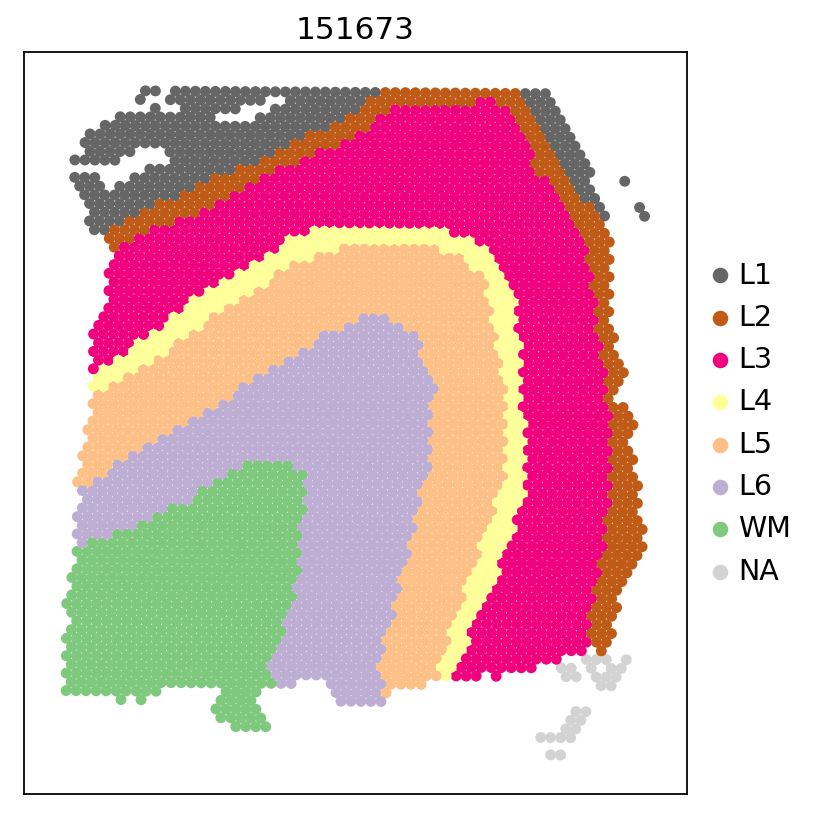

In [22]:
# plot_cell_layers(adata_spatialLIBD_151673.obs)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_d[SAMPLE_ID_N],
    img_key=None,
    color="spatialLIBD",
    palette="Accent_r",
    size=1.5,
    title=SAMPLE_ID_N,
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax,
)

ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")

fig.show()


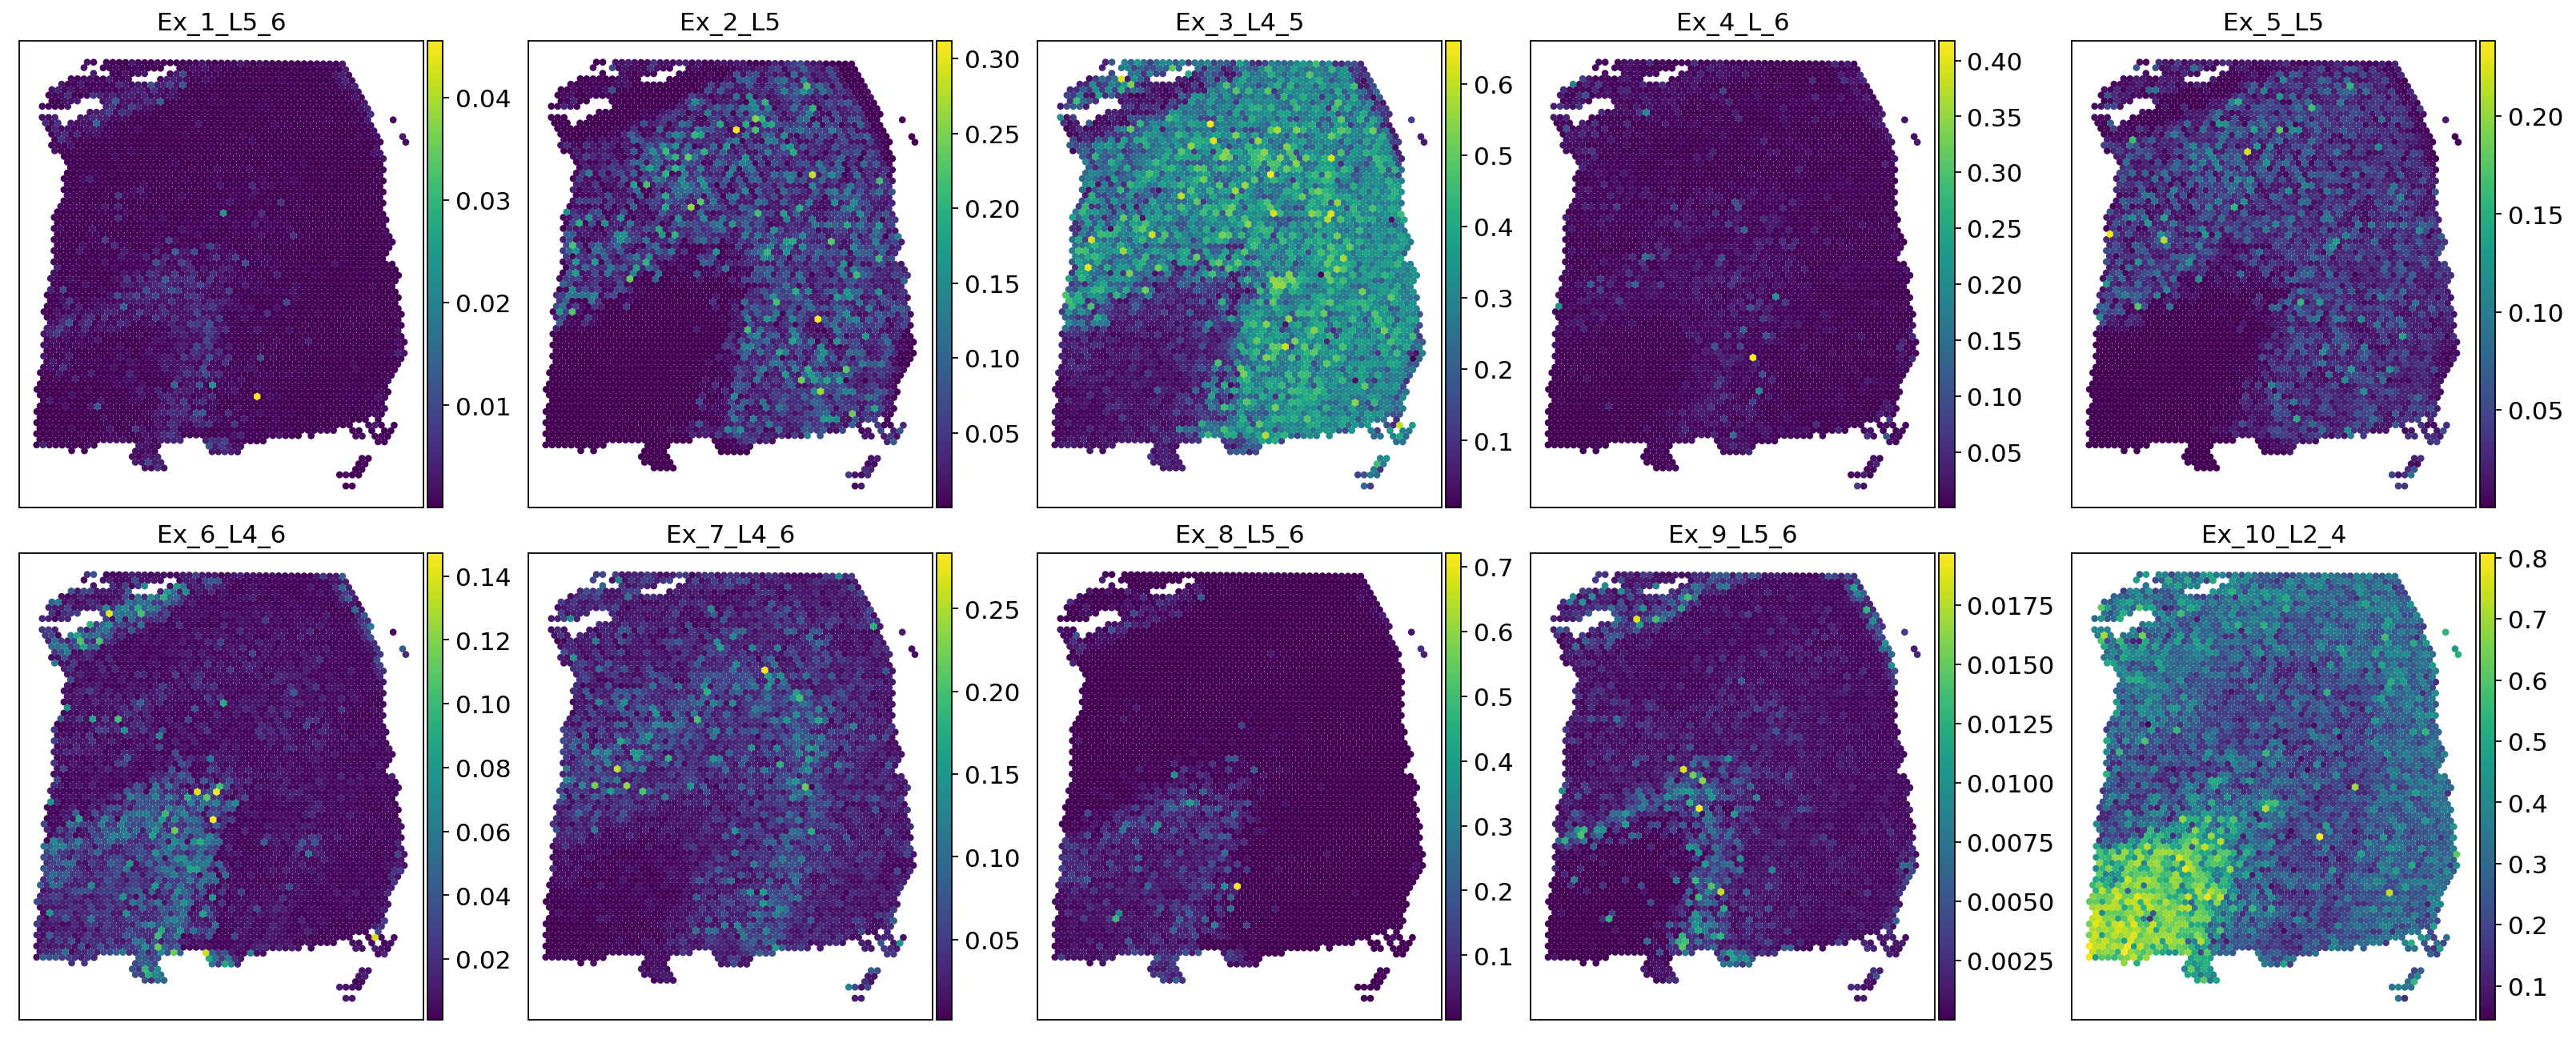

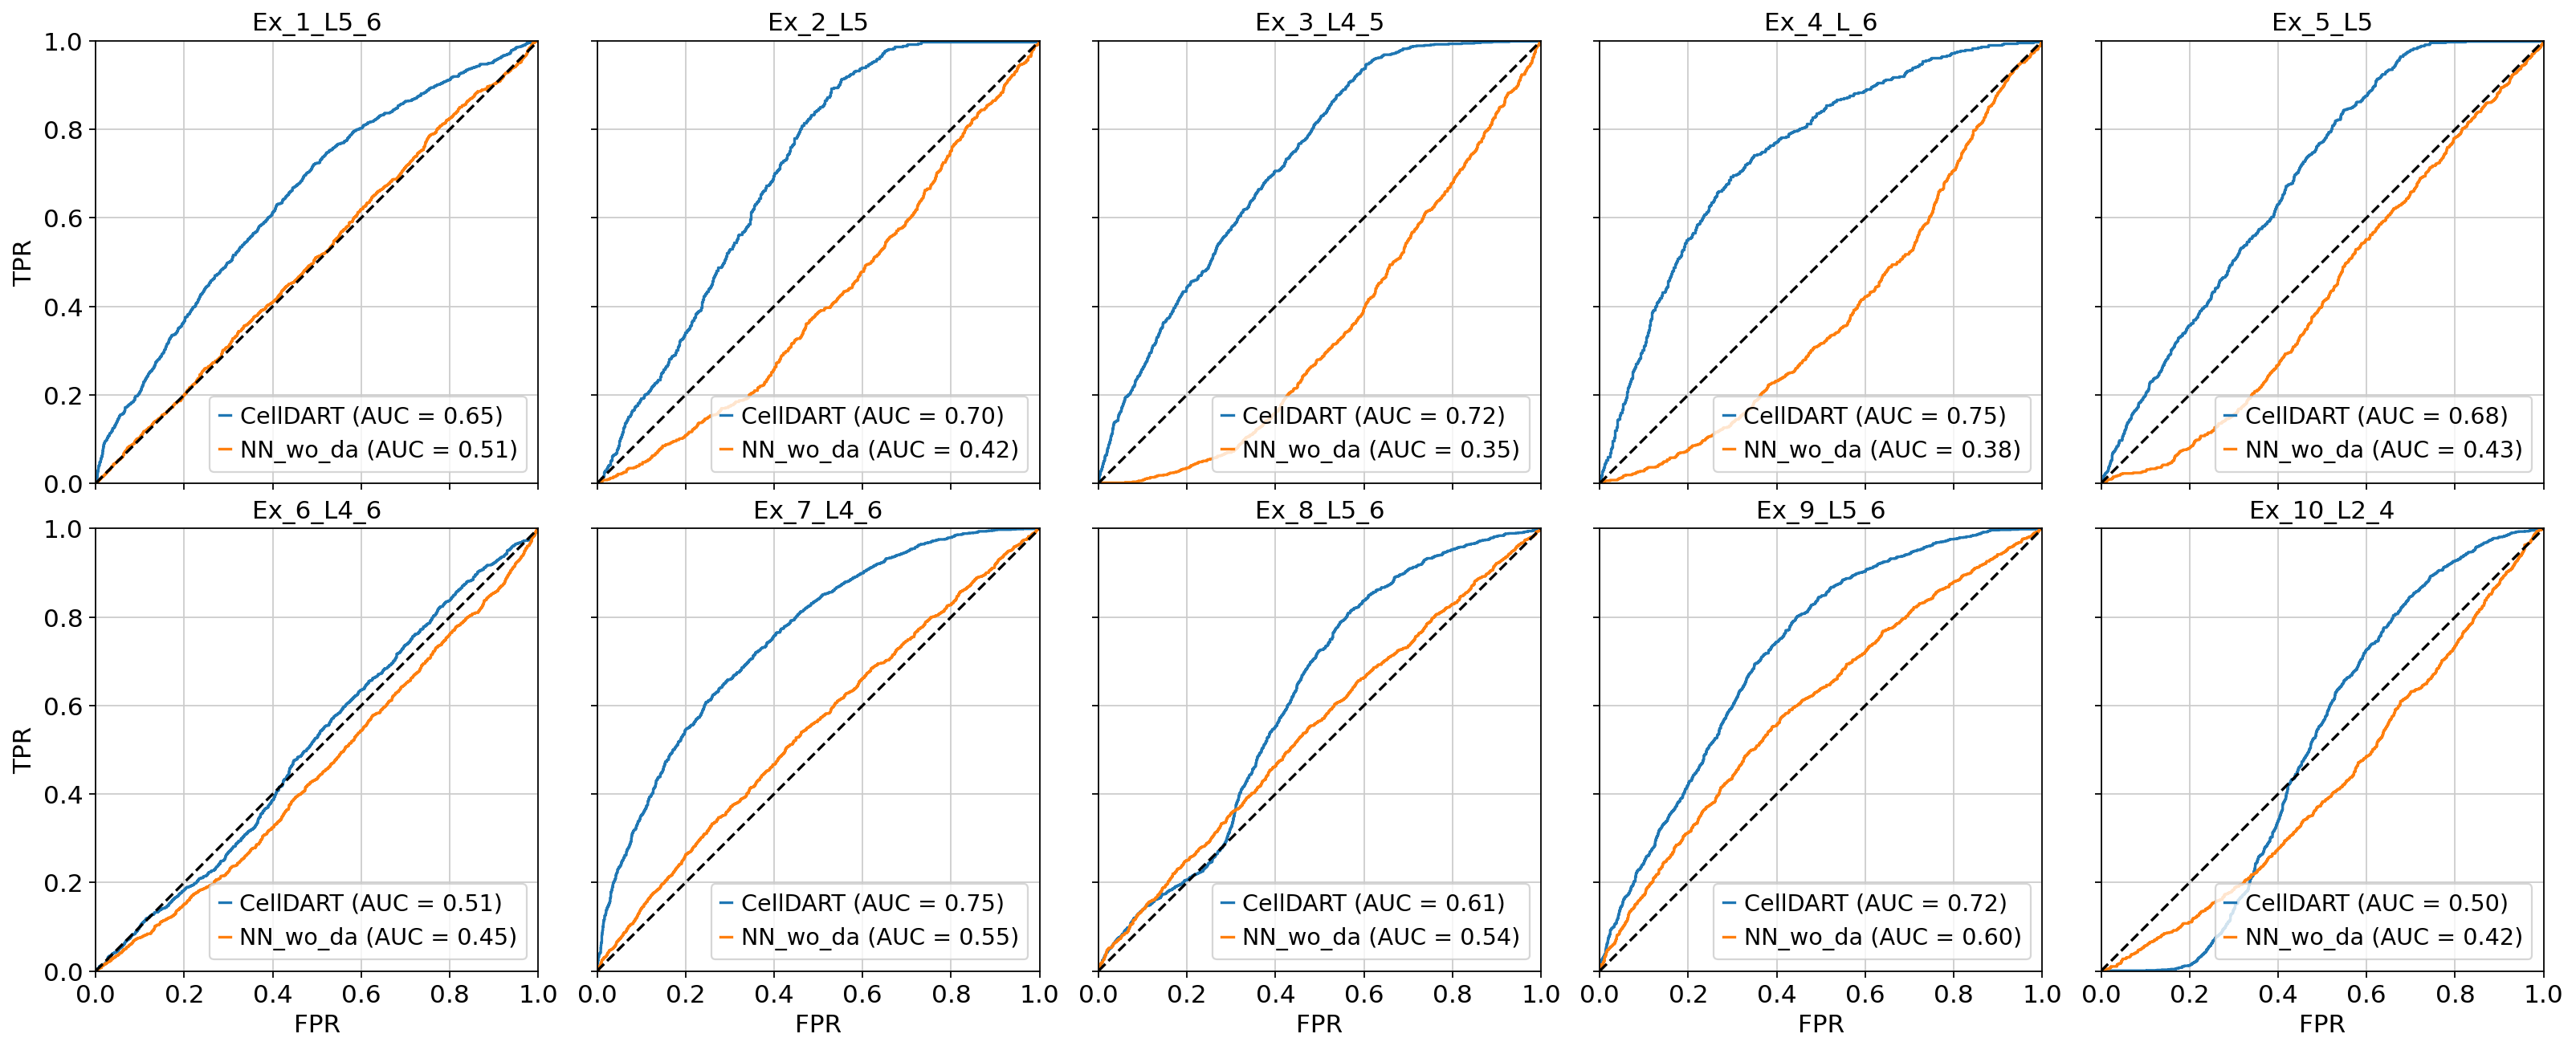

In [23]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(
        num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
    )
    ax.flat[i].axis("equal")
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")

fig.show()
# plt.close()

fig, ax = plt.subplots(
    2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
)

for i, num in enumerate(numlist):
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_d[SAMPLE_ID_N],
        "CellDART",
        ax.flat[i],
    )
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_noda_d[SAMPLE_ID_N],
        "NN_wo_da",
        ax.flat[i],
    )
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    ax.flat[i].set_title(f"{sc_sub_dict[num]}")

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel("FPR")
    else:
        ax.flat[i].set_xlabel("")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("TPR")
    else:
        ax.flat[i].set_ylabel("")

fig.show()
# plt.close()


- cf. Prediction of Mixture (pseudospots)


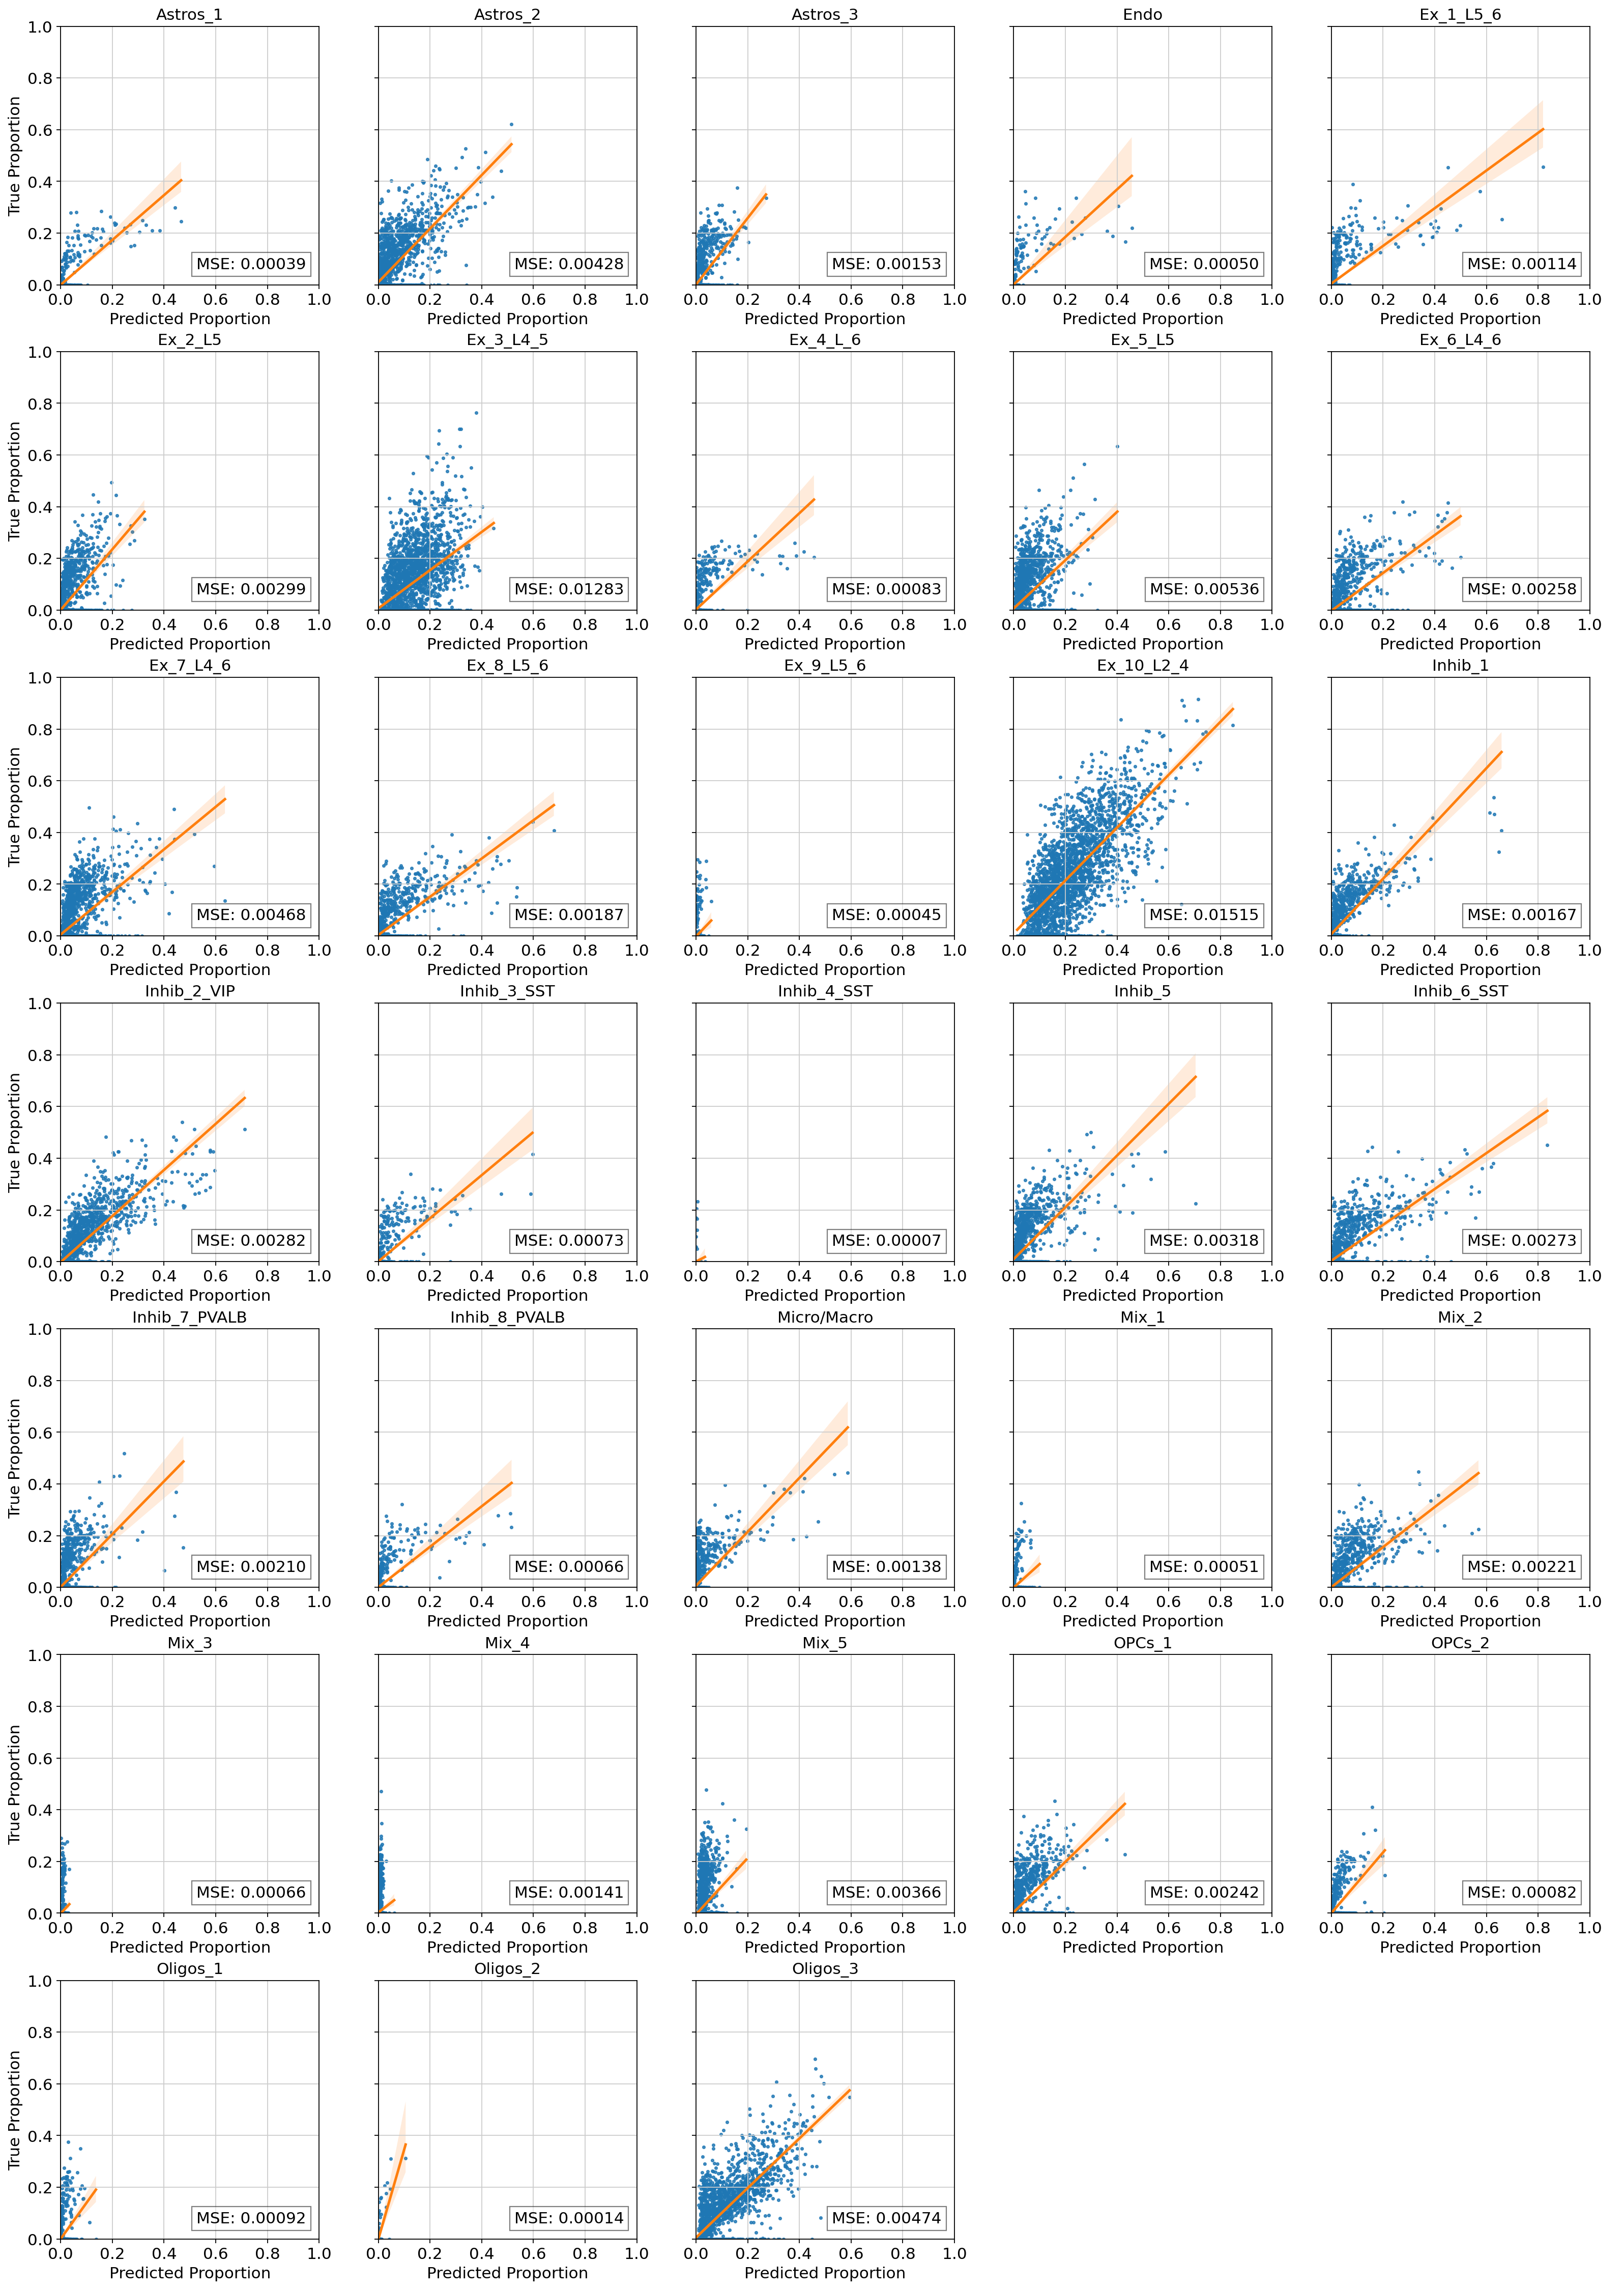

In [24]:
if TRAIN_USING_ALL_ST_SAMPLES:
    pred_mix = clssmodel.predict(sc_mix_test_s)
else:
    pred_mix = clssmodel_d[SAMPLE_ID_N].predict(sc_mix_test_s)


cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {"color": "tab:orange"}
scatter_kws = {"s": 5}

props = dict(facecolor="w", alpha=0.5)

fig, ax = plt.subplots(
    nrows,
    5,
    figsize=(20, 4 * nrows),
    constrained_layout=True,
    sharex=False,
    sharey=True,
)
for i, num in enumerate(cell_type_nums):
    sns.regplot(
        x=pred_mix[:, num],
        y=lab_mix_test[:, num],
        line_kws=line_kws,
        scatter_kws=scatter_kws,
        ax=ax.flat[i],
    ).set_title(sc_sub_dict[num])
    ax.flat[i].set_aspect("equal")

    ax.flat[i].set_xlabel("Predicted Proportion")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("True Proportion")
    else:
        ax.flat[i].set_ylabel("")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    textstr = f"MSE: {mean_squared_error(pred_mix[:,num], lab_mix_test[:,num]):.5f}"

    # place a text box in upper left in axes coords
    ax.flat[i].text(
        0.95,
        0.05,
        textstr,
        transform=ax.flat[i].transAxes,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
    )

for i in range(len(cell_type_nums), nrows * 5):
    ax.flat[i].axis("off")

plt.show()


In [25]:
print(
    "\n".join(
        f"{m.__name__} {m.__version__}"
        for m in globals().values()
        if getattr(m, "__version__", None)
    )
)


anndata 0.8.0
numpy 1.20.3
pandas 1.4.3
scanpy 1.9.1
seaborn 0.11.2
